# __ULMFiT Sentiment Analysis of US Airlines__

## Chapter 1. ULMFiT Intro
---
---


[ULMFiT Resource - Howard, Ruder 2018](https://arxiv.org/pdf/1801.06146.pdf)

## I. ___The Whats...___
---
#### _i. What is ULMFiT?_
- Universal Language Model Fine-tuning for Text Classification
- Uses transfer learning method
---
#### _ii. What are ULMFiT's benefits?_

  - Addresses NLP problems with small datasets and computational resources
  - Makes NLP problems easier to solve
  - Outperforms state of the art methods on 6 separate text classification tasks
  - Reduces error 18-24% on majority of datasets
  - matches performance of training from scratch with only 100 labeled samples!!!
---
#### _iii. What is Transfer Learning?_
- A ML problem that stores knowledge gained from solving one problem that directly applies or transfers that knowledge to a related problem
- Common approach is by fine tuning original model
- Simple models use a single layer of weights (embeddings)

## II. ___The Whys___
---

#### a. ULMFiT - Why is it significant? & Findings

- Controlling how fast the model learns allows for better adaptability
- Learns well from a limited number of examples
- Performs better than traditional NLP methods
- Requires magnitude of 100X less data than current state of the art methods

## III. ___The Hows___
---------
#### i. Pretrain Language Model on general corpus
- Preprocess data, normalize, drop nas, use Average SWD Long Short Term Memory Model

#### ii. Fine-tune new dataset
- Apply
    - Discriminative fine-tuning
        - Tunes each layer in neural network with different learning rates
        - Stochastic gradient descent accounts for another variable - theta with respect to the layer
    - Slanted triangular learning rate
        - For adapting params, we want the model to converge quickly
        - First linearly increases learning rate
        - Then linearly decays

#### iii. Text classifier

In [20]:
# -----------------------------------
# import dependencies
# -----------------------------------
import io
import os
import re
import sys
sys.path.append('C:\\Users\\Krcly\\Projects\\air-sent\\env\\Lib\\site-packages')
import fastai
from fastai import *
from fastai.text import *
from functools import partial
from nltk.corpus import stopwords 
import numpy as np
import pandas as pd
from pynvml import *
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# setup gpu for faster train times
t_gpu = torch.rand(500, 500, 500).cuda()
%timeit t_gpu @ t_gpu

89.6 µs ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Chapter I. Preprocess Data
---

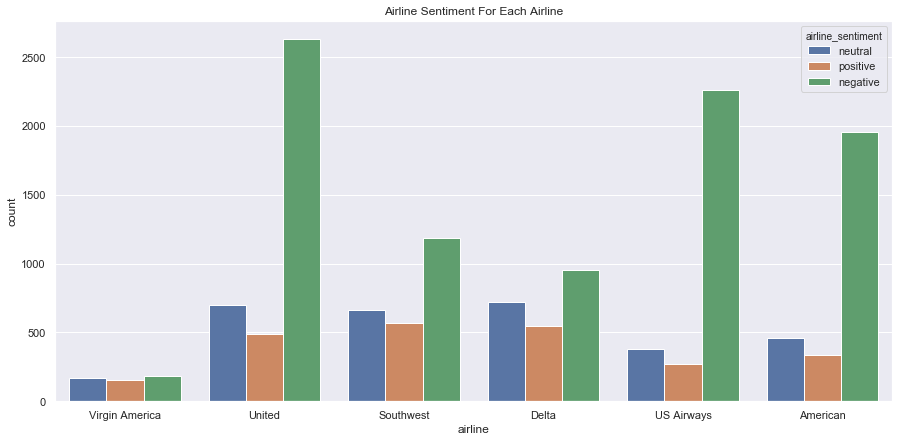

In [3]:
# -----------------------------------
# a. Load Data
# -----------------------------------
df = pd.read_csv('resources/Tweets.csv', encoding='ISO-8859-1')
# -----------------------------------
# b. Visualize Sentiment
# -----------------------------------
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15,7)})
sns.countplot(x="airline", hue='airline_sentiment', data=df)
plt.title("Airline Sentiment For Each Airline");
df = pd.DataFrame({'text': df.text, 'label': df.airline_sentiment})

In [4]:
# -----------------------------------
# c. Encode Categories as Int Type
# -----------------------------------
label_dict = {'negative': 0, 'neutral': 2, 'positive': 4}
df.label = df.label \
  .apply(lambda x: label_dict[x])
# -----------------------------------
# d. Preprocess - Clean
#    ==================
#    - Replace airline tag to reduce
#      error in model
#    - Check NA counts
# -----------------------------------
regex = r"@(VirginAmerica|united|SouthwestAir|Delta|USAirways|AmericanAir)"
df['text'] = df['text'].apply( \
  lambda x: re.sub(regex, '@airline', x, flags=re.IGNORECASE))
df.text = df.text.str.replace("[^a-zA-Z]", " ")

In [5]:
# -----------------------------------
# e. Check Distribution of Labels to
#    Reduce Bias
# -----------------------------------
print('Airline Sentiment Value Counts\n' + 
      f'{df.label.value_counts()}')
print('\nText NaN Counts\n' + 
      f'{df.isna().sum()}')

Airline Sentiment Value Counts
0    9178
2    3099
4    2363
Name: label, dtype: int64

Text NaN Counts
text     0
label    0
dtype: int64


In [6]:
# -----------------------------------
# f. Create a More Even Distribution
#    of Label Types for Model
#    ===============================
# 
#      - 3X as more negative labels 
#        compared to neutral and
#        positive
# 
#      - Randomly sample 3,000 negative
#        labels to train model with more
#        fair representation of data!!!
# 
# -----------------------------------
df = pd.concat([ df[ df.label.isin( [2, 4] ) ], \
                 df[ df.label==0].sample(3000) ])
df = df.reset_index(drop=True)
df.label.value_counts()

2    3099
0    3000
4    2363
Name: label, dtype: int64

In [7]:
# -----------------------------------
# g. Tokenize
# -----------------------------------
tokenized = df.text.apply(lambda x: x.split())
# -----------------------------------
# h. Remove Stopwords
# -----------------------------------
stop_words = stopwords.words('english')
tokenized = tokenized.apply(lambda x: \
  [item for item in x if item.lower() not in stop_words] )
# -----------------------------------
# i. De-tokenize
# -----------------------------------
detokenized = []
for i in range(len(df)):
  toke = ' '.join(tokenized[i])
  detokenized.append(toke)
df.text = detokenized

In [8]:
# -----------------------------------
# j. Split into train and validation sets
# -----------------------------------
trn_data, val_data = train_test_split( df, stratify=df.label, \
                                        test_size=0.4, random_state=12)

# _Chapter II. Pretrain & ASGD Weight Dropped LSTM_
---
[ASGD Weight Dropped LSTM](https://arxiv.org/abs/1708.02182)

## I. The Whats

- What Language Model Should we Use?

  - ULMFiT suggests using ASGD Weight Dropped LSTM for our pretrained model in step 1

- What is ASGD Weight-Dropped LSTM?

  - It's a popular Long Short Term Memory Language Model (type of Recurrent Neural Network) that has a unique set of regularization techniques to improve performance

  - Uses DropConnect on hidden-to-hidden weights as form of recurrent regularization

- What is a Recurrent Neural Network?

  - Networks with loops to allow for persisting information by passing it from one step of the network to the next

  - Take the human brain for example
  
      - We don't make decisions by starting from scratch
      
      - Use our past experiences and knowledge to pass judgement and carry out our decision making process

  - Can be thought of multiple copies of the same network, passing message to each successor

  - RNNs are capable of long term dependencies

  - However, there's a point where this gap between relevant information and point where more context is needed grows to be too large for RNNs
  
    - To a point where they are unable to learn and make connections

  - This is where Long Shert Term Memory networks come into play!

- What is LSTM?

  - Special kind of RNN capable of learning long term dependencies

  - Introduced by Hochreiter & Schmidhuber (1997)
  
    - http://www.bioinf.jku.at/publications/older/2604.pdf

  - What sets LSTM apart from a regular RNN?
  
    - RNNs have form of a chain of repeating modules - with a single tanh layer for the structure
    
    - Whereas the LSTM has 4 neural network layers of interaction.

  - Key to LSTM is cell state - horizontal line running through the entire chain of layers

  - Has ability to add/remove information to cell state with structures called gates

  - Gates regulate information traffic

  - Composed of a sigmoid neural net layer and a pointwise multiplication operator

  - Sigmoid layer outputs number 0-1 describing information permeability

  - 0 means:

  ![](https://media.giphy.com/media/njYrp176NQsHS/giphy.gif)


  - 1 means:

  ![](https://media.giphy.com/media/lHQuX9d5DBhug/giphy.gif)


- What is ASGD Weight Dropped LSTM?

  - RNN recurrent connections are prone to overfitting

  - Dropouts have been very successful in feed forward and convulational neural networks

  - However, applying dropouts similarly to RNN's hidden state is ineffective, disrupts long term retention ability

  - To counter this problem, DropConnect is proposed

  - Typically in Dropout, randomly selected subset of activations is set to zero within each layer

  - DropConnect, instead of activations, randomly selected subset of weights within the network is set to zero

  - Each unit receives input from random subset of units in previous layer

# Chapter III. Finetune
----
[Hyper Parameter Fine Tuning - Learning Rate, Momentum, Weight Decay](https://arxiv.org/pdf/1803.09820.pdf)

CUDA not avail


epoch,train_loss,valid_loss,accuracy,time
0,6.048579,4.858688,0.224241,00:03


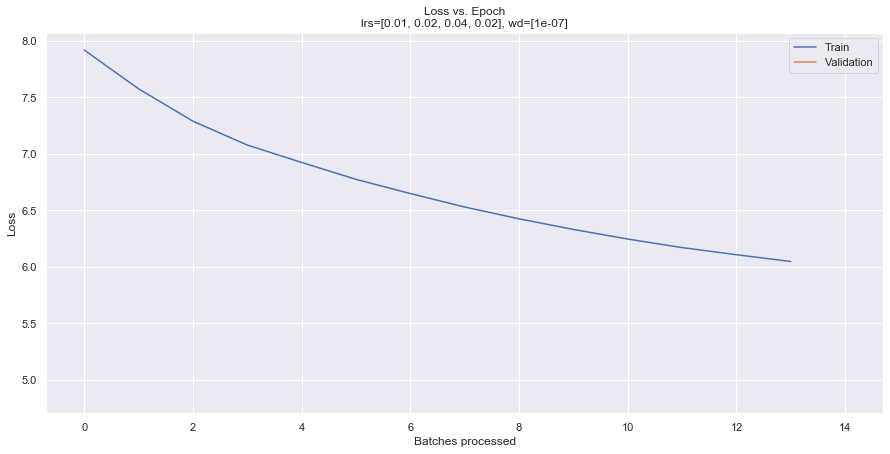

In [9]:
from universal import *
mdl = ULMFiT(4e-2)
mdl.finetune('label', 'text', trn_data, val_data, drop_mult=0.7, max_lr=4e-2, cyc_len=1)

# Chapter IV. Classify & Predict
---

CUDA Not Avail...


epoch,train_loss,valid_loss,accuracy,time
0,0.980797,0.904830,0.566322,00:52


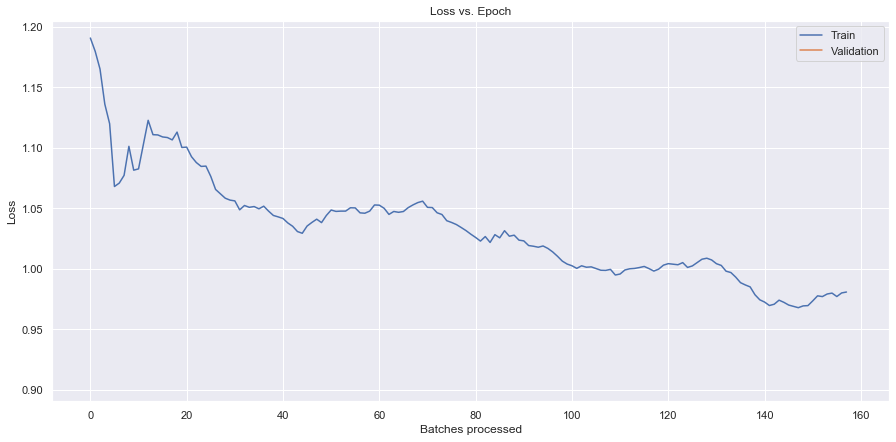

In [10]:
learner = mdl.classify()

In [21]:
# testing positive category
learner.predict('I loved this airline')

(Category tensor(2), tensor(2), tensor([0.2127, 0.1481, 0.6391]))

In [22]:
# testing negative category
learner.predict('airline messed everything up for me!')

(Category tensor(0), tensor(0), tensor([0.6250, 0.1746, 0.2005]))

In [23]:
# resting neutral category
learner.predict('my experience with airline was average')

(Category tensor(0), tensor(0), tensor([0.5731, 0.1918, 0.2350]))